In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
import statsmodels.api as sm
from scipy import stats

from plastockmethods import name_zones, name_particles, name_frequentation, name_situation
from plastockmethods import particle_groups, name_substrate, name_distance, table_css_styles

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df

work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
wide_form = pd.read_csv("data/aggregated_micro_results.csv")
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")

wdx = work_data.copy()
wdx["position"] = wdx.position.apply(lambda x: name_zones[x])
wdx["frequentation"] = wdx.frequentation.apply(lambda x: name_frequentation[x])
wdx["situation"] = wdx.situation.apply(lambda x: name_situation[x])
wdx["distance"] = wdx.distance.apply(lambda x: name_distance[x])
wdx["substrat"] = wdx.substrat.apply(lambda x: name_substrate[x])

# Modèles linéaires

Les méthodes suivantes sont destinées à la régression dans laquelle la valeur cible est censée être une combinaison linéaire des caractéristiques. Si $\hat{y}$ est la valeur prédite: $\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p$

__Méthodes :__

1. statsmodels: [statsmodels linear regression](https://www.statsmodels.org/stable/regression.html)
2. sklearn: [scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html)

## Les considérations (liste non exhaustive)

### Valeurs non négatives

Les coefficients doivent être non négatifs parce qu'ils représentent des quantités physiques ou naturelles non négatives.

1. distance
2. fréquentation
3. calibre de substrat
4. situation: degré d'urbanisation

### Colinéarité des variables indépendantes

La multicolinéarité est un problème courant dans l'analyse de régression lorsque les variables indépendantes d'un modèle de régression sont fortement corrélées entre elles. Cela peut créer des problèmes dans l'interprétation du modèle et la stabilité des estimations des coefficients.

__Variables catégorielles ordinales :__ Avec les variables catégorielles ordinales (c'est-à-dire les catégories avec un ordre significatif), la multicolinéarité peut se produire si les catégories sont étroitement espacées ou s'il existe une forte corrélation entre la variable ordinale et une autre variable continue ou catégorielle.

L'utilisation de l'analyes des composantes principale (ACP) avec la régression linéaire peut aider à atténuer la multicolinéarité et à réduire le risque de surajustement lorsque vous avez un grand nombre de caractéristiques corrélées. Toutefois, il est essentiel de trouver un équilibre entre le nombre de composantes principales retenues et la variance qu'elles expliquent, car une réduction trop agressive de la dimensionnalité peut entraîner une perte d'informations et de pouvoir prédictif.

### Variables catégorielles

L'analyse de régression porte généralement sur des variables dépendantes et indépendantes continues (numériques). Si ces résultats comportent des variables indépendantes catégorielles, il existe des techniques et des modèles spécifiques pour les intégrer dans une analyse de régression. Les variables catégorielles peuvent être nominales (catégories non ordonnées) ou ordinales (catégories ordonnées).

__approches courantes pour incorporer des variables catégorielles dans l'analyse:__

__Régression par variable muette :__ (variable indicatrice) : Il s'agit de l'approche la plus courante lorsqu'il s'agit de variables catégorielles nominales. Vous créez des variables fictives binaires (0 ou 1) pour représenter les catégories. Pour une variable catégorielle comportant k catégories, vous créez k-1 variables nominales. La catégorie omise sert de catégorie de référence. Chaque variable muette indique si une observation appartient ou non à une catégorie spécifique. Ces variables binaires sont ensuite incluses en tant que variables prédictives dans le modèle de régression.

__Codage de l'effet :__ Le codage de l'effet est une alternative au codage muette, et il est utilisé lorsque vous souhaitez comparer chaque catégorie à la moyenne générale. Il crée k-1 variables nominales, mais au lieu de comparer chaque catégorie à une catégorie de référence, il compare chaque catégorie à la moyenne générale.

__Régression ordinale :__ Les modèles de régression ordinale s'addresse dans les cas dont les catégories ont un ordre naturel (par exemple, faible, moyen, élevé). Ces modèles tiennent compte de la nature ordinale de la variable et estiment l'impact des catégories sur la variable dépendante en tenant compte de leur ordre.

### Les données

In [2]:
caption = "Les données sont regroupées en deux groupes par échantillon: 1. fibres, 2. fragment. Note: Les résultats sont échelonnés entre 0 et 1 au moment de l'analyse."

# columns of interest
x_cols = ['echantillon','position','orientation',  'frequentation', 'situation', 'distance', 'substrat', 'objet']
y_col = ["compte"]

# combine the fragments
w_fragments = wdx[wdx.objet.isin(["souple", "fdure"])].copy()

souple_d = w_fragments.groupby([*x_cols[:-1]], as_index=False).compte.sum()
souple_d["objet"] = "fragment"

# isolate the fibres
fibres = wdx[wdx.objet.isin(["fibres"])].copy()

# combine the aggregate fragments and the fibres
w_d = pd.concat([souple_d[[*x_cols, *y_col]], fibres[[*x_cols, *y_col]]])
w_d.drop_duplicates(x_cols, inplace=True)

w_d.head().style.set_table_styles(table_css_styles).set_caption(caption)

,echantillon,position,orientation,frequentation,situation,distance,substrat,objet,compte
0,74_Amp_1,ligne-d'eau,NE,élévée,campagne,< 100m,galet,fragment,0
1,74_Amp_10,plage-seche,NNE,élévée,campagne,< 100m,galet,fragment,62
2,74_Amp_2,ligne-d'eau,NNE,élévée,campagne,< 100m,galet,fragment,15
3,74_Amp_3,ligne-d'eau,NE,élévée,campagne,< 100m,galet,fragment,0
4,74_Amp_4,ligne-d'eau,NNE,élévée,campagne,< 100m,galet,fragment,3


## Colinéarité

__Les données sont fournies dans une catégorie ordinale pour la plupart des variables catégorielles.__

In [3]:
from sklearn.preprocessing import MinMaxScaler

co_data = w_d.copy()
encode_cols = ['substrat','frequentation', 'situation', 'distance', 'orientation']
x_dum = pd.get_dummies(co_data[encode_cols], drop_first=False)
model_data = pd.concat([co_data[['echantillon', 'compte']], x_dum], ignore_index=False, axis=1)

stdsc = MinMaxScaler()

X = model_data[x_dum.columns]
y = model_data.drop([*x_dum.columns, 'echantillon'], axis=1)
y['compte'] = stdsc.fit_transform(y)

In [4]:
# from table A2-2
f = w_d.substrat.value_counts()
weights = [{x:f.loc[x]/f.sum() for x in f.index}]
weights

[{'sable fin': 0.5253456221198156,
  'galet': 0.2119815668202765,
  'gravier': 0.1336405529953917,
  'sable grosssier': 0.12903225806451613}]

In [5]:
for use in encode_cols:
    n = co_data[(co_data.substrat == 'sable fin')].groupby(use).echantillon.nunique()
    
    t = co_data.groupby(use).echantillon.nunique()
    # print(t.sum())
    print(f'{n/t.sum()}\n')

substrat
sable fin    0.525346
Name: echantillon, dtype: float64

frequentation
moyenne    0.027650
élévée     0.497696
Name: echantillon, dtype: float64

situation
campagne    0.317972
urbain      0.207373
Name: echantillon, dtype: float64

distance
100 - 500m    0.299539
< 100m        0.225806
Name: echantillon, dtype: float64

orientation
N      0.036866
NE     0.129032
NNE    0.013825
NO     0.027650
O      0.027650
ONO    0.018433
OSO    0.009217
S      0.064516
SO     0.142857
SSE    0.023041
SSO    0.032258
Name: echantillon, dtype: float64



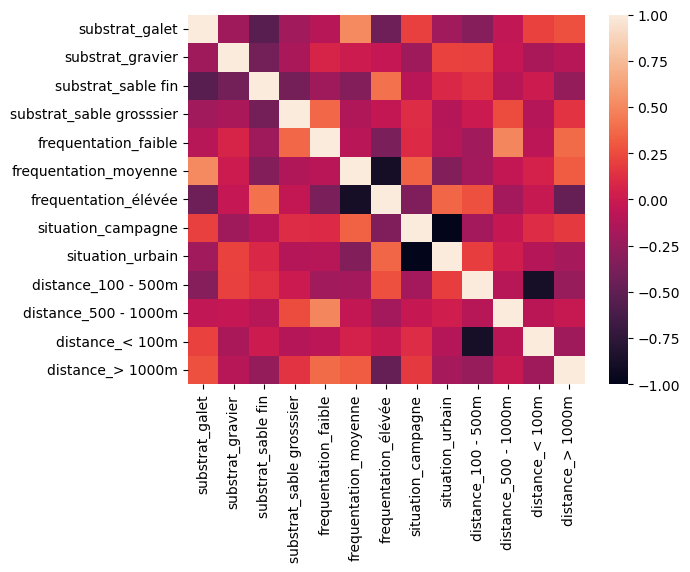

In [6]:
usage = ['substrat_galet', 'substrat_gravier', 'substrat_sable fin',
       'substrat_sable grosssier', 'frequentation_faible',
       'frequentation_moyenne', 'frequentation_élévée', 'situation_campagne',
       'situation_urbain', 'distance_100 - 500m', 'distance_500 - 1000m',
       'distance_< 100m', 'distance_> 1000m']


correlate_columns = model_data.columns[2:]
cor_matrix = model_data[correlate_columns].corr()
heatmap_data = cor_matrix.loc[usage, usage]

fig, ax = plt.subplots()

sns.heatmap(heatmap_data, )

plt.show()

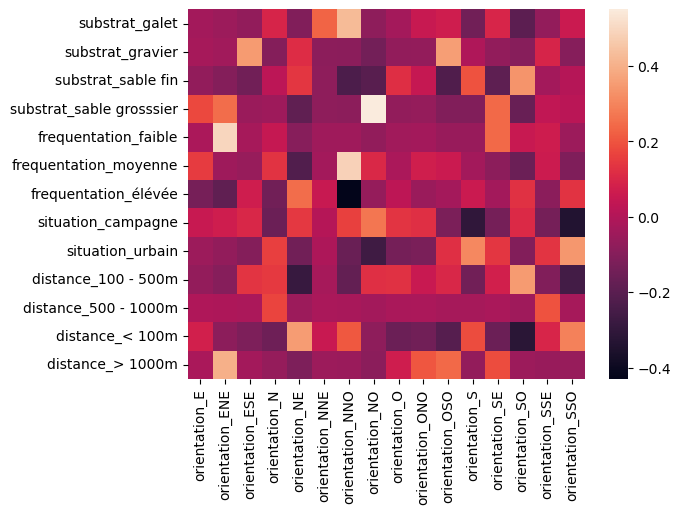

In [7]:
orientation  =  ['orientation_E',
       'orientation_ENE', 'orientation_ESE', 'orientation_N', 'orientation_NE',
       'orientation_NNE', 'orientation_NNO', 'orientation_NO', 'orientation_O',
       'orientation_ONO', 'orientation_OSO', 'orientation_S', 'orientation_SE',
       'orientation_SO', 'orientation_SSE', 'orientation_SSO']

heatmap_data = cor_matrix.loc[usage, orientation]

fig, ax = plt.subplots()

sns.heatmap(heatmap_data)

plt.show()

In [8]:
# Create an empty DataFrame to store p-values
p_values = pd.DataFrame(index=cor_matrix.index, columns=cor_matrix.columns)

# Loop through the columns and rows of the correlation matrix
for col1 in cor_matrix.columns:
    for col2 in cor_matrix.columns:
        if col1 != col2:
            # Calculate the Pearson correlation coefficient and its p-value
            corr, p_value = stats.pearsonr(model_data[col1], model_data[col2])
            p_values.at[col1, col2] = p_value


p_mask = p_values <= 0.05
pd.concat([p_mask['substrat_sable fin'], cor_matrix['substrat_sable fin']], axis=1)

,substrat_sable fin,substrat_sable fin
substrat_galet,True,-0.545651
substrat_gravier,True,-0.413194
substrat_sable fin,False,1.000000
substrat_sable grosssier,True,-0.404932
frequentation_faible,True,-0.205829
frequentation_moyenne,True,-0.329746
frequentation_élévée,True,0.401541
situation_campagne,False,-0.087728
situation_urbain,False,0.087728
distance_100 - 500m,True,0.133124


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate


from sklearn.preprocessing import StandardScaler, OneHotEncoder
categorical_features = ['orientation', 'frequentation', 'situation', 'distance', 'objet']

X = w_d[[*categorical_features]].copy()
y = w_d.drop(w_d.columns[:-1], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# transformer for categorical features
categorical_features = ['orientation', 'frequentation', 'situation', 'distance', 'objet']
numeric_features = ['compte']
categorical_transformer =  OneHotEncoder(handle_unknown = 'ignore')

# transformer for numerical features
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ('one-hot-encoder', categorical_transformer, categorical_features),
        ('standard_scaler', numeric_transformer, numeric_features)
    ],
    remainder = 'drop'
)

pipeline = Pipeline(steps=
    [
        ('preprocessing', preprocessor),
        ('clf', LinearRegression())
    ]
)

from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LinearRegression())
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['orientation',
                                                   'frequentation', 'situation',
                                                   'distance', 'objet']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['compte'])])),
                ('linearregression', LinearRegression())])

In [10]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# Create a DataFrame with sample data (replace this with your data)
data = {'Cat1': ['A', 'B', 'A', 'C', 'B'],
        'Cat2': ['X', 'Y', 'Z', 'X', 'Z'],
        'Cat3': ['M', 'N', 'N', 'M', 'N'],
        'Cat4': ['High', 'Low', 'Medium', 'Low', 'High'],
        'Cat5': ['Yes', 'No', 'Yes', 'No', 'No'],
        'Target': [10, 12, 8, 15, 11]}

df = pd.DataFrame(data)

# List of categorical column names and target variable name
categorical_cols = ['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5']
target_col = 'Target'

# Define the transformations for the pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a column transformer to apply transformations to appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, [target_col])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reduce_dim', PCA(n_components=3)),  # You can adjust the number of components
    ('regressor', LinearRegression())
])

# Split data into X (features) and y (target)
X = df.drop(target_col, axis=1)
y = df[target_col]

# Fit the pipeline on the data
# pipeline.fit(X, y)

# # Predict using the pipeline
# y_pred = pipeline.predict(X)

# # You can now assess the model's performance and use it for predictions
# y_pred = pipeline.predict(X_test)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Cat1', 'Cat2', 'Cat3',
                                                   'Cat4', 'Cat5']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Target'])])),
                ('reduce_dim', PCA(n_components=3)),
                ('regressor', LinearRegression())])

In [11]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: glm_p

scipy      : 1.10.1
statsmodels: 0.13.5
numpy      : 1.24.2
matplotlib : 3.7.1
pandas     : 2.0.0
seaborn    : 0.12.2

